In [3]:
!pip install monai
!pip install nibabel
!pip install tqdm
!pip install opencv-python pycocotools --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.8 MB/s eta 0:00:00


In [4]:
import os
import json
import cv2
import numpy as np
from pycocotools.coco import COCO
from google.colab import drive

import torch
from torch.utils.data import DataLoader

from monai.data import Dataset, CacheDataset
from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    ScaleIntensityD,
    ToTensorD,
)
from monai.config import print_config
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.66.6
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.46.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="92jyh8UFL7X56QYAPtge")
project = rf.workspace("rf-projects").project("x-ray-id")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to X-Ray-ID-1 in coco:: 100%|██████████| 3847/3847 [00:00<00:00, 7627.65it/s]


In [7]:
!ls

sample_data  X-Ray-ID-1


In [9]:
def create_mask_for_image(coco, img_info, image_dir, image_size=None):
    """
    Create a binary mask for a given image from its bounding boxes in COCO annotations.
    Assume that each annotation in COCO has 'bbox' = [x, y, w, h].
    """
    img_path = os.path.join(image_dir, img_info['file_name'])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    h, w = img.shape[:2]

    mask = np.zeros((h, w), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=[img_info['id']])
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        # ann['bbox'] = [x, y, width, height]
        x, y, bw, bh = ann['bbox']
        x, y, bw, bh = int(x), int(y), int(bw), int(bh)
        # Fill the mask with 1s in the bounding box area
        mask[y:y+bh, x:x+bw] = 1

    # Optionally resize if needed
    if image_size is not None:
        mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
    return mask


In [10]:
data_dir = "./X-Ray-ID-1"  # adjust if needed
train_img_dir = os.path.join(data_dir, "train")
val_img_dir = os.path.join(data_dir, "valid")
train_ann_file = os.path.join(train_img_dir, "_annotations.coco.json")
val_ann_file = os.path.join(val_img_dir, "_annotations.coco.json")

# Initialize COCO APIs
coco_train = COCO(train_ann_file)
coco_val = COCO(val_ann_file)

train_img_ids = coco_train.getImgIds()
val_img_ids = coco_val.getImgIds()

train_data = []
for img_id in train_img_ids:
    img_info = coco_train.loadImgs([img_id])[0]
    mask = create_mask_for_image(coco_train, img_info, train_img_dir)
    mask_path = os.path.join(train_img_dir, img_info['file_name'].replace('.jpg', '_mask.png'))
    cv2.imwrite(mask_path, mask)
    train_data.append({"image": os.path.join(train_img_dir, img_info['file_name']),
                       "mask": mask_path})

val_data = []
for img_id in val_img_ids:
    img_info = coco_val.loadImgs([img_id])[0]
    mask = create_mask_for_image(coco_val, img_info, val_img_dir)
    mask_path = os.path.join(val_img_dir, img_info['file_name'].replace('.jpg', '_mask.png'))
    cv2.imwrite(mask_path, mask)
    val_data.append({"image": os.path.join(val_img_dir, img_info['file_name']),
                     "mask": mask_path})


loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [11]:
from monai.transforms import (
    LoadImageD, EnsureChannelFirstD, ScaleIntensityD, ToTensorD, Compose, EnsureTypeD
)

train_transforms = Compose([
    LoadImageD(keys=["image", "mask"]),
    EnsureChannelFirstD(keys=["image", "mask"]),
    ScaleIntensityD(keys=["image"]),
    EnsureTypeD(keys=["image", "mask"]),
    ToTensorD(keys=["image", "mask"]),
])

val_transforms = Compose([
    LoadImageD(keys=["image", "mask"]),
    EnsureChannelFirstD(keys=["image", "mask"]),
    ScaleIntensityD(keys=["image"]),
    EnsureTypeD(keys=["image", "mask"]),
    ToTensorD(keys=["image", "mask"]),
])

train_ds = Dataset(data=train_data, transform=train_transforms)
val_ds = Dataset(data=val_data, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2)


In [14]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7  # 6 classes + 1 background

model = UNet(
    spatial_dims=2,
    in_channels=3,        # assuming RGB input; if grayscale, set this to 1
    out_channels=num_classes,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2)
).to(device)

# DiceLoss with softmax to handle multiple classes
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [15]:
max_epochs = 5

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        images = batch_data["image"].to(device)
        masks = batch_data["mask"].to(device)
        masks = (masks > 0.5).long()  # convert mask to integer class labels: 0 or 1

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{max_epochs}, Avg Loss: {epoch_loss:.4f}")


Epoch 1/5, Avg Loss: 0.7613
Epoch 2/5, Avg Loss: 0.7368
Epoch 3/5, Avg Loss: 0.7329
Epoch 4/5, Avg Loss: 0.7317
Epoch 5/5, Avg Loss: 0.7308


In [16]:
model.eval()
val_loss = 0
with torch.no_grad():
    for val_batch in val_loader:
        v_images = val_batch["image"].to(device)
        v_masks = val_batch["mask"].to(device)
        v_masks = (v_masks > 0.5).long()
        v_outputs = model(v_images)
        v_loss = loss_function(v_outputs, v_masks)
        val_loss += v_loss.item()

val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss:.4f}")


Validation Loss: 0.7311


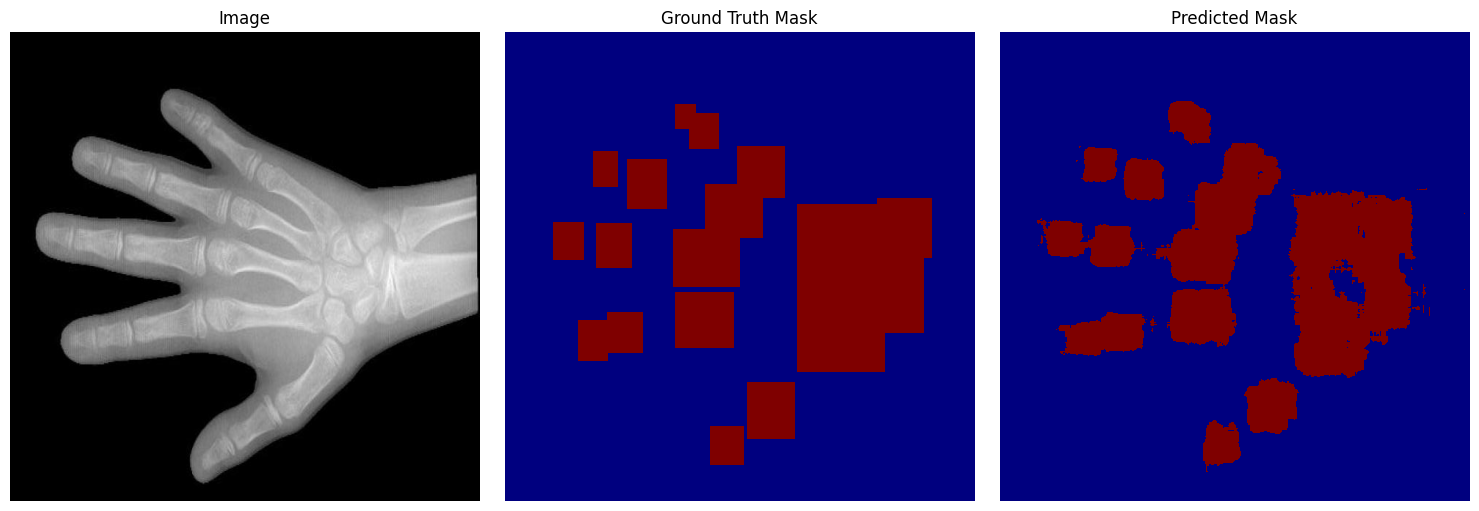

In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    val_batch = next(iter(val_loader))
    val_images = val_batch["image"].to(device)
    val_masks = val_batch["mask"].cpu().numpy()  # ground truth masks
    outputs = model(val_images)

    # If using DiceLoss with softmax=True, outputs are probabilities.
    # Otherwise, you may need to apply softmax manually:
    # outputs = F.softmax(outputs, dim=1)

    # Convert probabilities to predicted class for each pixel
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

# Let's visualize the first item in the batch
idx = 0

# Convert tensors to numpy for plotting
image_np = val_batch["image"][idx].permute(1, 2, 0).cpu().numpy()
# Depending on your image normalization, you might want to scale it back,
# here we assume it's already in a displayable range [0,1] or [0,255].

gt_mask_np = gt_mask_np.squeeze()     # Remove extra dimension
pred_mask_np = pred_mask_np.squeeze() # Remove extra dimension

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_np.astype('uint8') if image_np.max()>1 else image_np, cmap='gray')
axes[0].set_title("Image")
axes[0].axis('off')

axes[1].imshow(gt_mask_np, cmap='jet', interpolation='nearest')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

axes[2].imshow(pred_mask_np, cmap='jet', interpolation='nearest')
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()



In [19]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.eval()
with torch.no_grad():
    for val_batch in val_loader:
        images = val_batch["image"].to(device)
        labels = val_batch["mask"].to(device)
        outputs = model(images)

        # For multi-class with softmax: convert outputs to probabilities
        # and take the argmax to get predicted classes
        pred_classes = torch.argmax(outputs, dim=1, keepdim=True)

        # DiceMetric expects one-hot encoded masks. If your labels are integers:
        # Convert labels and predictions to one-hot:
        # Note: If you have `num_classes` classes:
        num_classes = outputs.shape[1]
        labels_onehot = torch.zeros((labels.size(0), num_classes, labels.size(2), labels.size(3)), device=labels.device)
        labels_onehot.scatter_(1, labels.long(), 1)

        preds_onehot = torch.zeros_like(labels_onehot)
        preds_onehot.scatter_(1, pred_classes.long(), 1)

        dice_metric(preds_onehot, labels_onehot)

dice_score = dice_metric.aggregate().item()
print(f"Validation Mean Dice: {dice_score:.4f}")
dice_metric.reset()


Validation Mean Dice: 0.9414
